In [1]:
import random
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import matplotlib
import numpy as np
import os
import imageio
from random import seed
seed(42)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

import tensorflow
import keras
from keras import optimizers
from keras.models import Sequential, load_model, Model
from keras.callbacks import TensorBoard
from keras.activations import elu
from keras.initializers import he_normal
from keras.preprocessing import image
from keras.layers import Conv2D, Dense, Activation, Flatten, MaxPooling2D, Dropout, Input
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from numpy.testing import assert_allclose

import nibabel as nib
from nibabel.testing import data_path

from PIL import Image

import nilearn
from nilearn import image, plotting

import ggplot
from ggplot import aes
from ggplot import geom_point
from ggplot import ggtitle

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for mo

In [2]:
def get_subject(file_name): # parse out subjectids from file names
    return file_name[0:9]

In [3]:
def get_slice(orientation):
    
    path = '/Users/glynismattheisen/Desktop/Final/Discs'
    disc_list = os.listdir(path) # get list of discs from directory
    MacOS_file = '.DS_Store'
    if MacOS_file in disc_list:
        disc_list.remove(MacOS_file) # remove annoying MacOS file

    brain_list, total_subjects = [], [] # generate list of brain images for input to NN, all subjects used in study
    
    for disc in disc_list:
        path_ind_disc = f'{path}/{disc}'
        subject_list_p_disc = os.listdir(path_ind_disc) # generate list of subjects in each disc
        if MacOS_file in subject_list_p_disc:
            subject_list_p_disc.remove(MacOS_file) # remove annoying MacOS file
            
        for subj_id in subject_list_p_disc:
            total_subjects.append(subj_id) # maintain a list of all subjects included in study for diagnosis labeling later

            path_n4 = path_ind_disc + f'/{subj_id}/PROCESSED/MPRAGE/T88_111/{subj_id}_mpr_n4_anon_111_t88_gfc_{orientation[0]}_{orientation[1]}.gif'
            path_n3 = path_ind_disc + f'/{subj_id}/PROCESSED/MPRAGE/T88_111/{subj_id}_mpr_n3_anon_111_t88_gfc_{orientation[0]}_{orientation[1]}.gif'
            path_n6 = path_ind_disc + f'/{subj_id}/PROCESSED/MPRAGE/T88_111/{subj_id}_mpr_n6_anon_111_t88_gfc_{orientation[0]}_{orientation[1]}.gif'
            path_n5 = path_ind_disc + f'/{subj_id}/PROCESSED/MPRAGE/T88_111/{subj_id}_mpr_n5_anon_111_t88_gfc_{orientation[0]}_{orientation[1]}.gif'

            
            if os.path.exists(path_n4) == True:
                brain_list.append(plt.imread(path_n4)) # append if file format exists
            elif os.path.exists(path_n3) == True:
                brain_list.append(plt.imread(path_n3)) # append if file format exists
            elif os.path.exists(path_n6) == True:
                brain_list.append(plt.imread(path_n6)) # append if file format exists
            elif os.path.exists(path_n5) == True:
                brain_list.append(plt.imread(path_n5)) # append if file format exists
    
    return disc_list, brain_list, total_subjects

In [4]:
def get_diagnosis(total_subjects):
    oasis1 = pd.read_csv('/Users/glynismattheisen/Desktop/Final2/oasis_cross-sectional.csv') # read in summary file
    
    oasis1['CDR'].fillna(0, inplace=True) # null values are helathy diagnoses
    
    diagnosis={0.:'normal', 0.5:'alz', 1.:'alz', 2.:'alz' } # convert to labels
    oasis1 = oasis1.replace({"CDR": diagnosis})
    diagnosis={'normal':0,'alz':1} # convert back to numbers
    oasis1 = oasis1.replace({"CDR": diagnosis})
    
    subjects = []    # get subject names for each MRI from file names
    for subj_id in total_subjects:
        subjects.append(get_subject(subj_id))
        
    subjects = pd.DataFrame(subjects, columns = ['Subject'])
    
    # extract subject ID from MR ID
    oasis1['Subject'] =oasis1['ID'].apply(get_subject)
    
    # create a dictionary with subject and diagnosis
    diagnosis_dict= {}
    for num in range(0,436):
        diagnosis_dict[oasis1['Subject'][num]] = oasis1['CDR'][num]
        
    diag = []
    for x in subjects['Subject']:
        diag.append(diagnosis_dict[x])

    subjects['Diagnosis'] = pd.DataFrame(diag)
    
    return subjects

In [5]:
def balance_set(subjects, total_subjects, disc_list, orientation):
    alz_subjects = subjects.sort_values(by='Diagnosis', ascending = False).head(97) # all subjects diagnosed as alz
    # make a list of 236 alz patients in order to even out the lists
    alz_subjects = alz_subjects.append(alz_subjects)
    head = alz_subjects.head(42)
    alz_subjects = alz_subjects.append(head)    
    
    for i in alz_subjects['Subject']:
        total_subjects.append(str(i) + '_MR1') # maintain a list of all subjects included in study for diagnosis labeling later
    for disc in disc_list:
            path = f'/Users/glynismattheisen/Desktop/Final/Discs/{disc}'

            for i in alz_subjects['Subject']:

                path_n4 = path + f'/{i}_MR1/PROCESSED/MPRAGE/T88_111/{i}_MR1_mpr_n4_anon_111_t88_gfc_{orientation[0]}_{orientation[1]}.gif'
                path_n3 = path + f'/{i}_MR1/PROCESSED/MPRAGE/T88_111/{i}_MR1_mpr_n3_anon_111_t88_gfc_{orientation[0]}_{orientation[1]}.gif'
                path_n6 = path + f'/{i}_MR1/PROCESSED/MPRAGE/T88_111/{i}_MR1_mpr_n6_anon_111_t88_gfc_{orientation[0]}_{orientation[1]}.gif'
                path_n5 = path + f'/{i}_MR1/PROCESSED/MPRAGE/T88_111/{i}_MR1_mpr_n5_anon_111_t88_gfc_{orientation[0]}_{orientation[1]}.gif'

            
                if os.path.exists(path_n4) == True:
                    brain_list.append(plt.imread(path_n4)) # append if file format exists
                elif os.path.exists(path_n3) == True:
                    brain_list.append(plt.imread(path_n3)) # append if file format exists
                elif os.path.exists(path_n6) == True:
                    brain_list.append(plt.imread(path_n6)) # append if file format exists
                elif os.path.exists(path_n5) == True:
                    brain_list.append(plt.imread(path_n5)) # append if file format exists

    brain_array = np.asarray(brain_list)
    return brain_array, alz_subjects

In [6]:
disc_list, brain_list, total_subjects = get_slice(orientation = ['sag','95'])

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0448_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0448_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0449_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0449_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0439_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0439_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, for

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0222_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0222_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0223_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0223_MR1_mpr_n3_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0192_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0192_MR1_mpr_n3_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc7/OAS1_0246_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0246_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc7/OAS1_0239_MR2/PROCESSED/MPRAGE/T88_111/OAS1_0239_MR2_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc9/OAS1_0317_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0317_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc10/OAS1_0375_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0375_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc10/OAS1_0361_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0361_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc10/OAS1_0377_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0377_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, for

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc5/OAS1_0190_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0190_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc5/OAS1_0184_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0184_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc4/OAS1_0116_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0116_MR1_mpr_n3_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format

In [7]:
subjects = get_diagnosis(total_subjects)

In [8]:
brain_array, alz_subjects = balance_set(subjects, total_subjects, disc_list, orientation = ['sag','95'])

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0440_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0440_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0454_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0454_MR1_mpr_n3_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0441_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0441_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, for

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc5/OAS1_0185_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0185_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc5/OAS1_0184_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0184_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc5/OAS1_0179_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0179_MR1_mpr_n4_anon_111_t88_gfc_sag_95.gif'>
  return matplotlib.image.imread(fname, format

In [9]:
subjects = get_diagnosis(total_subjects)

In [10]:
shape = brain_array.shape
input_shape = shape[1]*shape[2]
shape

(666, 176, 208)

In [11]:
x = brain_array
y = np.asarray(subjects['Diagnosis'])

In [12]:
def norm(x):
    x = x.reshape(-1, 176,208,1)
    m = np.max(x)
    mi = np.min(x)
    x_norm = (x - mi) / (m - mi)
    assert (np.min(x_norm), np.max(x_norm)) == (0.0, 1.0)
    return x_norm

In [13]:
x_norm = norm(x)

In [14]:
X_im_train, X_im_test, y_im_train, y_im_test = train_test_split(x_norm,y, random_state = 42)

In [15]:
model = Sequential([
    Conv2D(filters=100,kernel_size=(3,3),strides=(10,10), input_shape=(176,208,1),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=50,kernel_size=(3,3),strides=(5,5),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=25,kernel_size=(3,3),strides=(1,1),padding ='same'),
    MaxPooling2D(pool_size=(1,1),padding='valid'),
    Activation('sigmoid'),
    Flatten(),
    Dense(1),
    Activation('sigmoid'),
])

In [16]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
model.fit(X_im_train,y_im_train,epochs=100, batch_size=75)

Epoch 1/100
499/499 [==============================] - 1s 1ms/step - loss: 0.6930 - acc: 0.5170
Epoch 2/100
499/499 [==============================] - 0s 745us/step - loss: 0.6957 - acc: 0.5010
Epoch 3/100
499/499 [==============================] - 0s 659us/step - loss: 0.6942 - acc: 0.4990
Epoch 4/100
499/499 [==============================] - 0s 581us/step - loss: 0.6944 - acc: 0.4990
Epoch 5/100
499/499 [==============================] - 0s 645us/step - loss: 0.6933 - acc: 0.4870
Epoch 6/100
499/499 [==============================] - 0s 587us/step - loss: 0.6938 - acc: 0.5010
Epoch 7/100
499/499 [==============================] - 0s 613us/step - loss: 0.6937 - acc: 0.4830
Epoch 8/100
499/499 [==============================] - 0s 564us/step - loss: 0.6935 - acc: 0.4990
Epoch 9/100
499/499 [==============================] - 0s 587us/step - loss: 0.6935 - acc: 0.4990
Epoch 10/100
499/499 [==============================] - 0s 558us/step - loss: 0.6932 - acc: 0.5331
Epoch 11/100
499/499 

499/499 [==============================] - 0s 619us/step - loss: 0.5187 - acc: 0.7836
Epoch 84/100
499/499 [==============================] - 0s 545us/step - loss: 0.5277 - acc: 0.7555
Epoch 85/100
499/499 [==============================] - 0s 585us/step - loss: 0.5031 - acc: 0.7956
Epoch 86/100
499/499 [==============================] - 0s 619us/step - loss: 0.5116 - acc: 0.7655
Epoch 87/100
499/499 [==============================] - 0s 556us/step - loss: 0.5069 - acc: 0.7655
Epoch 88/100
499/499 [==============================] - 0s 537us/step - loss: 0.4983 - acc: 0.7816
Epoch 89/100
499/499 [==============================] - 0s 616us/step - loss: 0.4925 - acc: 0.7796
Epoch 90/100
499/499 [==============================] - 0s 568us/step - loss: 0.4999 - acc: 0.7595
Epoch 91/100
499/499 [==============================] - 0s 558us/step - loss: 0.4860 - acc: 0.7856
Epoch 92/100
499/499 [==============================] - 0s 570us/step - loss: 0.4959 - acc: 0.7675
Epoch 93/100
499/499 [=

In [18]:
model.evaluate(X_im_test,y_im_test)

167/167 [==============================] - 0s 638us/step


[0.39920515205688817, 0.8622754491017964]

# Visualize the Input

Test Images


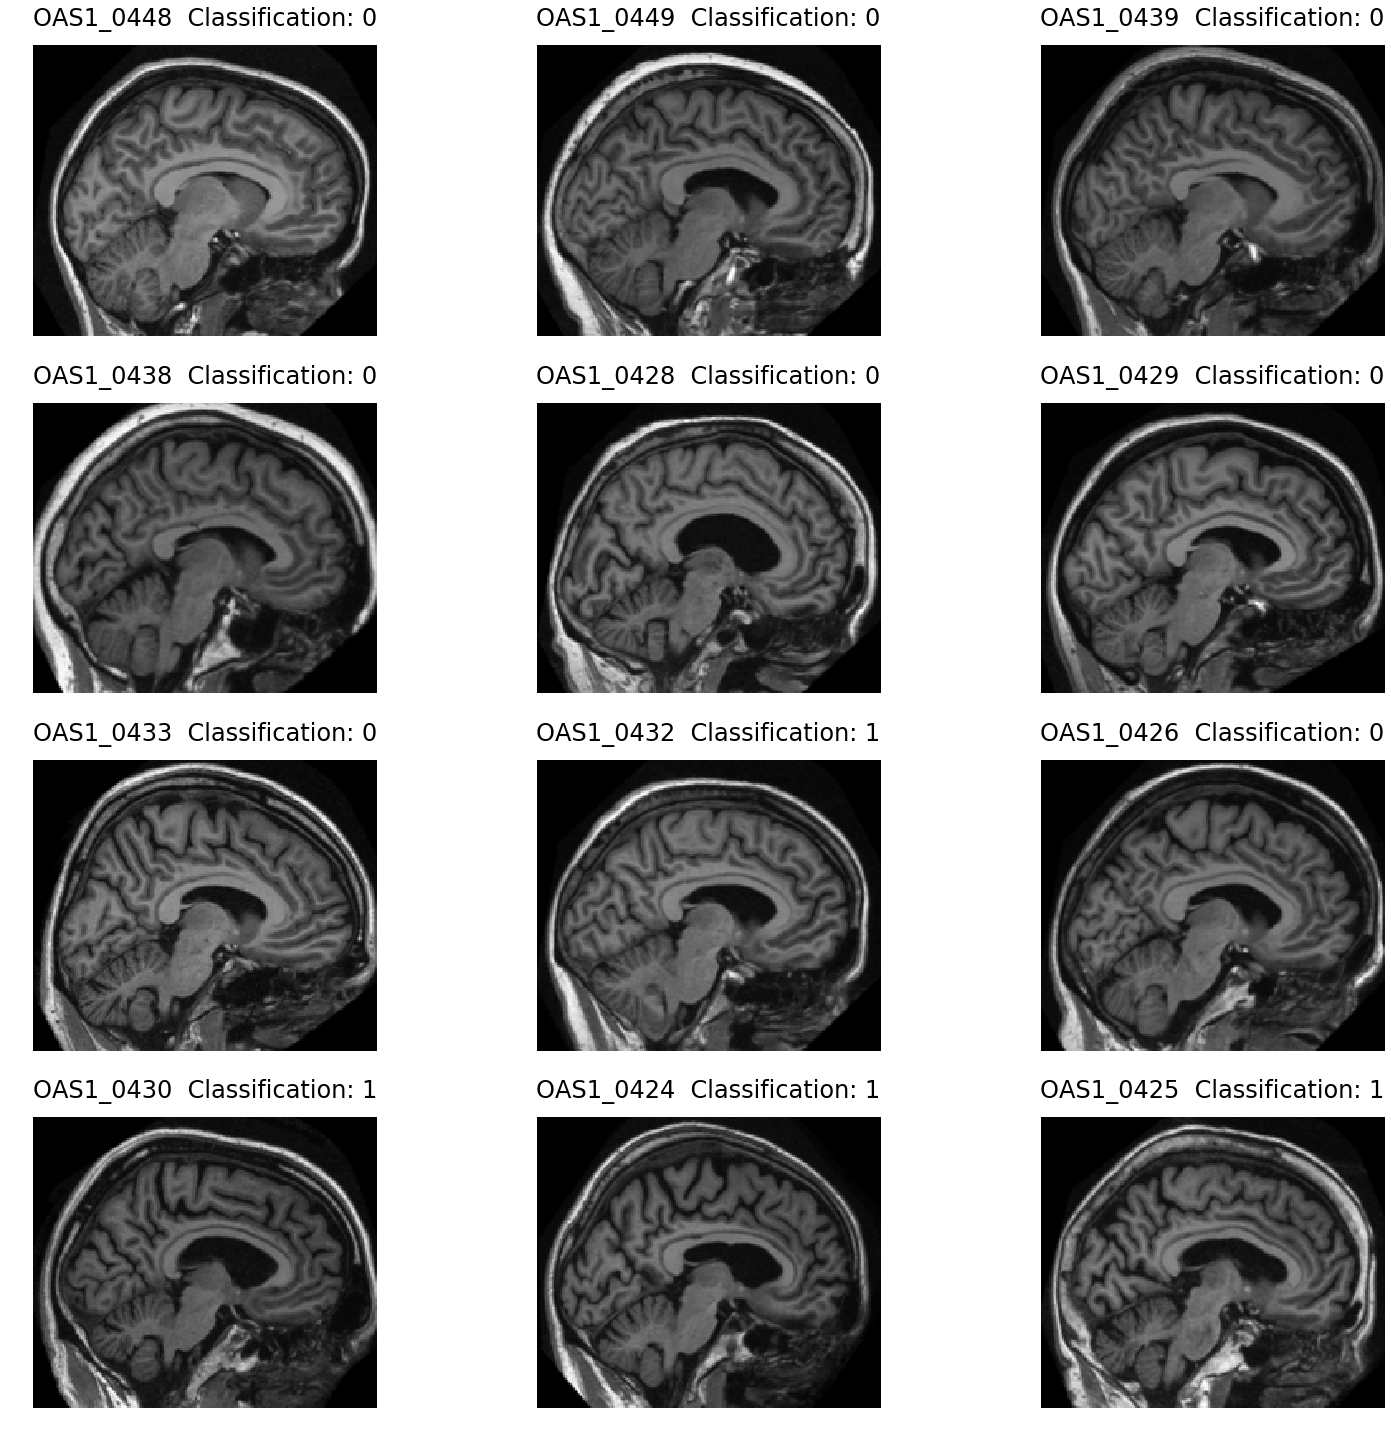

In [28]:
plt.figure(figsize=(20, 20))
print("Test Images")
for i in range(0,12):
    plt.subplot(4, 3, i+1)
    plt.title(str(subjects['Subject'][i]) +'  Classification: ' + str(subjects['Diagnosis'][i]), fontsize=24, pad = 20)
    plt.tight_layout()
    plt.imshow(brain_array[i], cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=0.25)
plt.show()    


# T-SNE

In [29]:
he = keras.initializers.he_normal(seed=42)

In [30]:
x.shape

(666, 176, 208)

In [31]:
tsne = TSNE(n_components=2, init='pca', random_state=42)
assert x.shape == (666, 176, 208)
X = x.reshape((666,208*176))
X_tsne = tsne.fit_transform(X)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [32]:
def run_tsne(x, y):
    X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_tsne,y, random_state = 42)
    
    model_t = Sequential([
    Dense(60, input_shape=(2,), kernel_initializer=he),
    Activation('sigmoid'),
    Dense(30),
    Activation('sigmoid'),
    Dense(15),
    Activation('sigmoid'),
    Dense(1),
    Activation('sigmoid'),
    ])
    optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_t.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return X, model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne

In [33]:
X, model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne= run_tsne(x,y)

In [34]:
# tboard = keras.callbacks.TensorBoard(log_dir='/Users/glynismattheisen/Desktop/Final',histogram_freq=5, write_graph=True, write_images=True)

In [35]:
model_t.fit(X_t_train,y_t_train,epochs=100, batch_size=50, validation_split=0.2)

Train on 399 samples, validate on 100 samples
Epoch 1/100
399/399 [==============================] - 0s 923us/step - loss: 0.8125 - acc: 0.5013 - val_loss: 0.6891 - val_acc: 0.5100
Epoch 2/100
399/399 [==============================] - 0s 45us/step - loss: 0.6900 - acc: 0.4987 - val_loss: 0.6803 - val_acc: 0.5100
Epoch 3/100
399/399 [==============================] - 0s 48us/step - loss: 0.6668 - acc: 0.5865 - val_loss: 0.6427 - val_acc: 0.6900
Epoch 4/100
399/399 [==============================] - 0s 31us/step - loss: 0.6389 - acc: 0.6717 - val_loss: 0.6260 - val_acc: 0.6900
Epoch 5/100
399/399 [==============================] - 0s 69us/step - loss: 0.6234 - acc: 0.6817 - val_loss: 0.6149 - val_acc: 0.6800
Epoch 6/100
399/399 [==============================] - 0s 34us/step - loss: 0.6146 - acc: 0.6617 - val_loss: 0.6052 - val_acc: 0.7000
Epoch 7/100
399/399 [==============================] - 0s 48us/step - loss: 0.6115 - acc: 0.6742 - val_loss: 0.6044 - val_acc: 0.7000
Epoch 8/100
399

399/399 [==============================] - 0s 48us/step - loss: 0.5346 - acc: 0.7118 - val_loss: 0.6181 - val_acc: 0.6400
Epoch 62/100
399/399 [==============================] - 0s 39us/step - loss: 0.5237 - acc: 0.7218 - val_loss: 0.6029 - val_acc: 0.6000
Epoch 63/100
399/399 [==============================] - 0s 52us/step - loss: 0.5250 - acc: 0.7168 - val_loss: 0.6059 - val_acc: 0.6300
Epoch 64/100
399/399 [==============================] - 0s 39us/step - loss: 0.5270 - acc: 0.7243 - val_loss: 0.6153 - val_acc: 0.6400
Epoch 65/100
399/399 [==============================] - 0s 43us/step - loss: 0.5376 - acc: 0.7068 - val_loss: 0.6313 - val_acc: 0.6200
Epoch 66/100
399/399 [==============================] - 0s 40us/step - loss: 0.5197 - acc: 0.7343 - val_loss: 0.6261 - val_acc: 0.6200
Epoch 67/100
399/399 [==============================] - 0s 45us/step - loss: 0.5167 - acc: 0.7193 - val_loss: 0.6346 - val_acc: 0.5800
Epoch 68/100
399/399 [==============================] - 0s 40us/step

In [36]:
model_t.evaluate(X_t_test,y_t_test)

167/167 [==============================] - 0s 38us/step


[0.6099678112896617, 0.6706586826347305]

In [37]:
prediction = model_t.predict_classes(X_t_test)

# Visualize the T-SNE

In [48]:
feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

# x, y = None, None

print ('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (666, 30977)


In [49]:
rndperm = np.random.permutation(df.shape[0])

<Figure size 432x288 with 0 Axes>

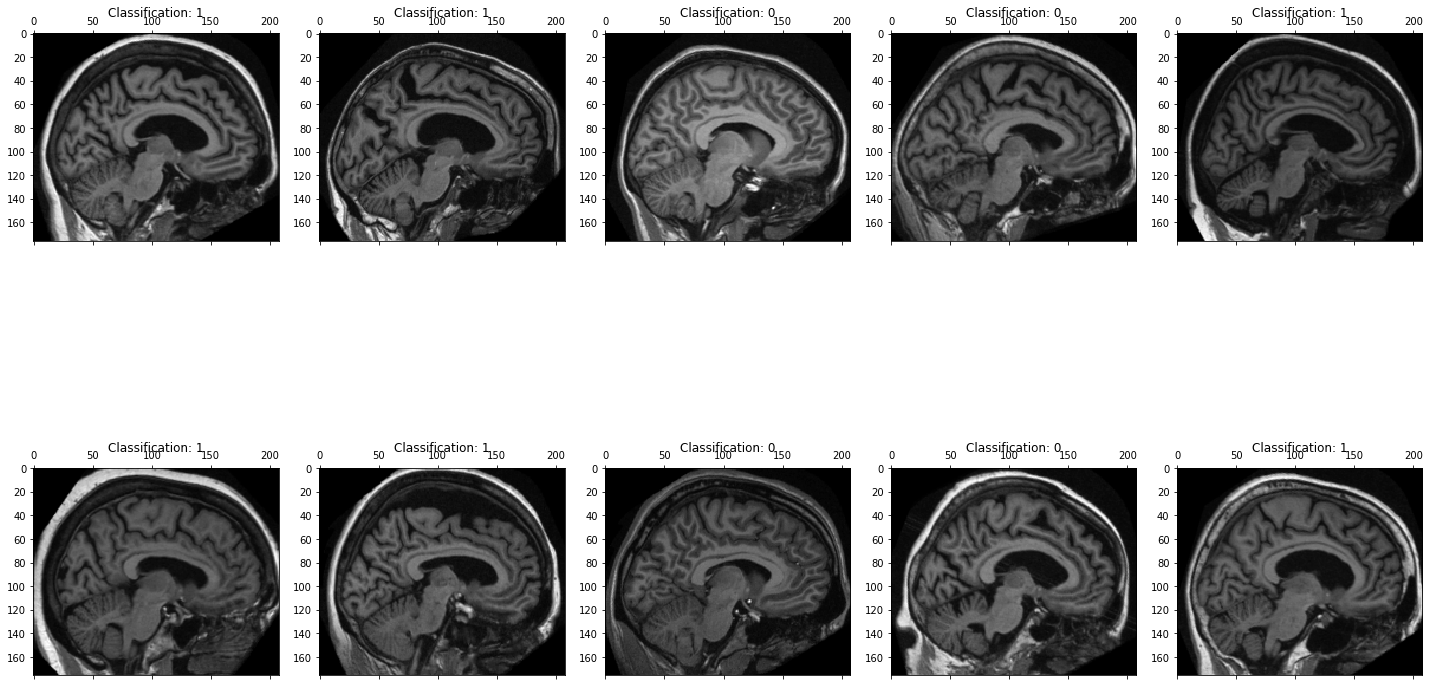

In [58]:
%matplotlib inline

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(20,20) )
for i in range(0,10):
    ax = fig.add_subplot(3,5,i+1, title='Classification: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((176,208)).astype(float))
    plt.tight_layout()
plt.show()

In [50]:
n_sne = 7000
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


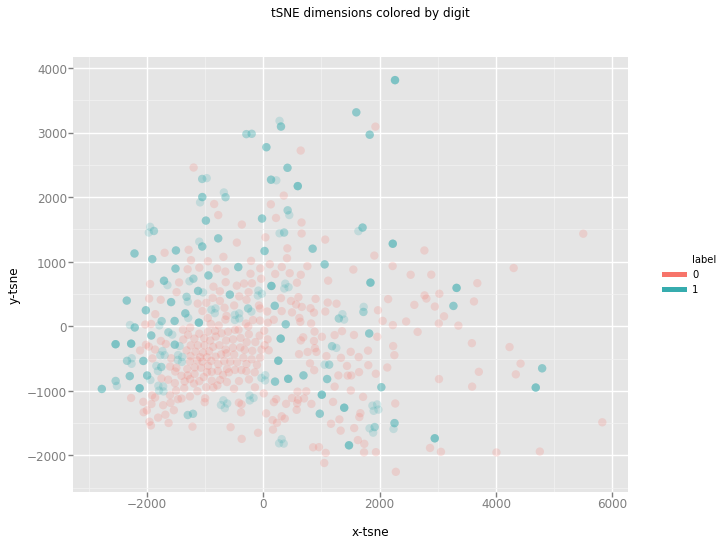

<ggplot: (-9223372029295127338)>

In [51]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

ggplot.ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label')) + geom_point(size=70,alpha=0.2) + ggtitle("tSNE dimensions colored by digit")

In [31]:
# --logdir=/Users/glynisttheisen/Desktop/Final

# PNCA

In [61]:
m_PCA = PCA(n_components=10)

In [62]:
X.shape

(666, 36608)

In [63]:
m_PCA.fit(X)
xt = m_PCA.transform(X)
xback = m_PCA.inverse_transform(xt)

In [64]:
xback.shape

(666, 36608)

In [69]:
xback = xback.reshape((666,176,208))

In [70]:
xback.shape

(666, 176, 208)

In [53]:
def draw(input):
    plt.figure(figsize=(20,20))

    for i in range(12):
        plt.subplot(4, 3, i+1)
        plt.title('Classification: ' + str(df.loc[rndperm[i],'label']), fontsize = 24, pad = 20)
        plt.imshow(input[i], cmap=plt.cm.Greys)
        plt.axis('off')
    plt.show()

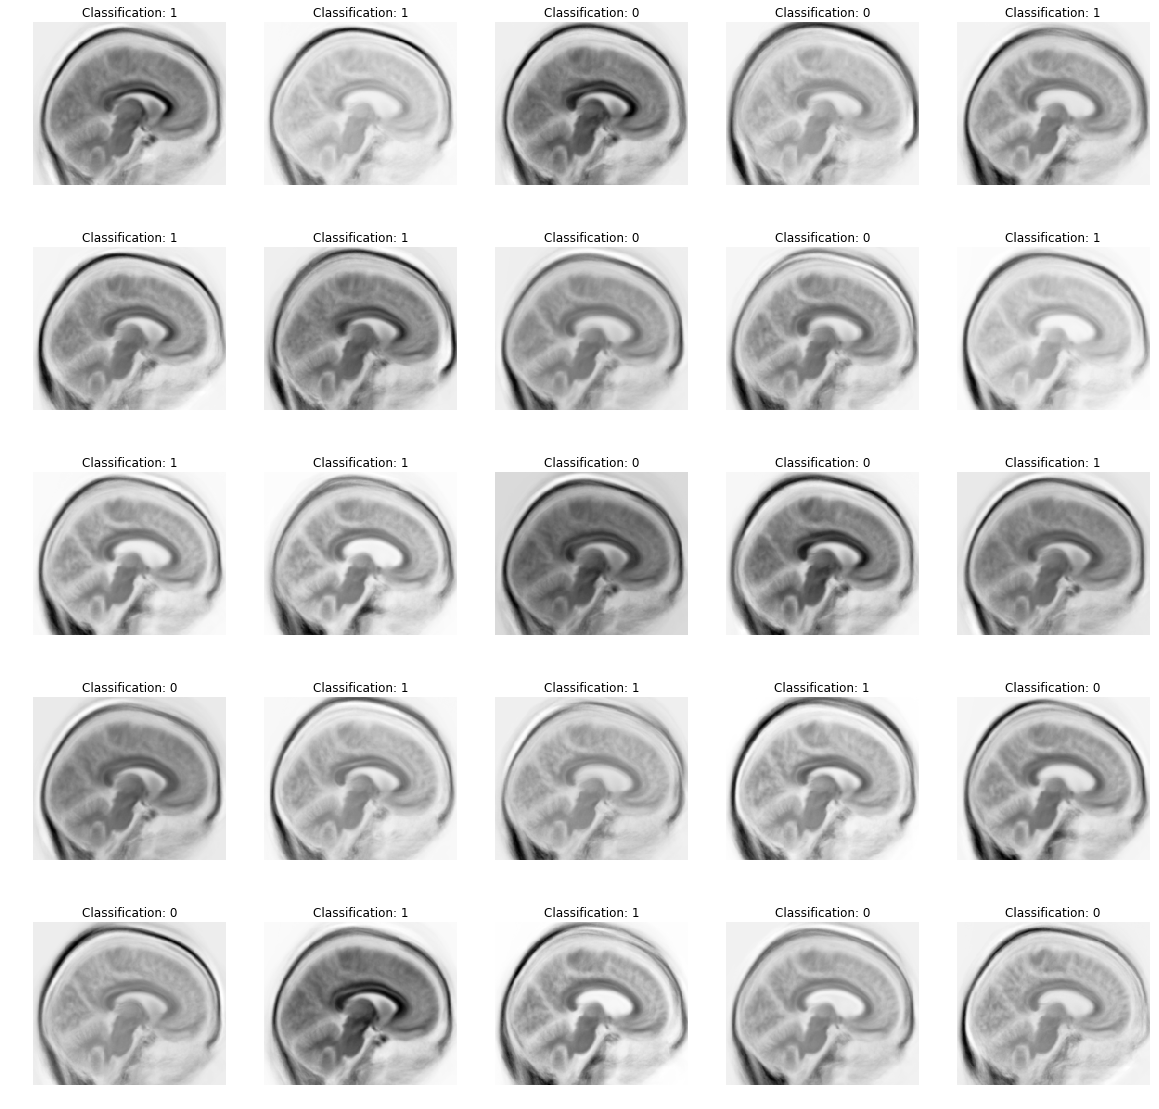

In [72]:
draw(xback)

# correct and incorrect predictions

In [113]:
wrong_predictions = []
correct_predictions = []
for i in range(167):
    if prediction[i][0] != y_t_test[i]:
        wrong_predictions.append(i)
    else:
        correct_predictions.append(i)

In [114]:
len(wrong_predictions)

59

In [115]:
len(correct_predictions)

108

ValueError: num must be 1 <= num <= 50, not 51

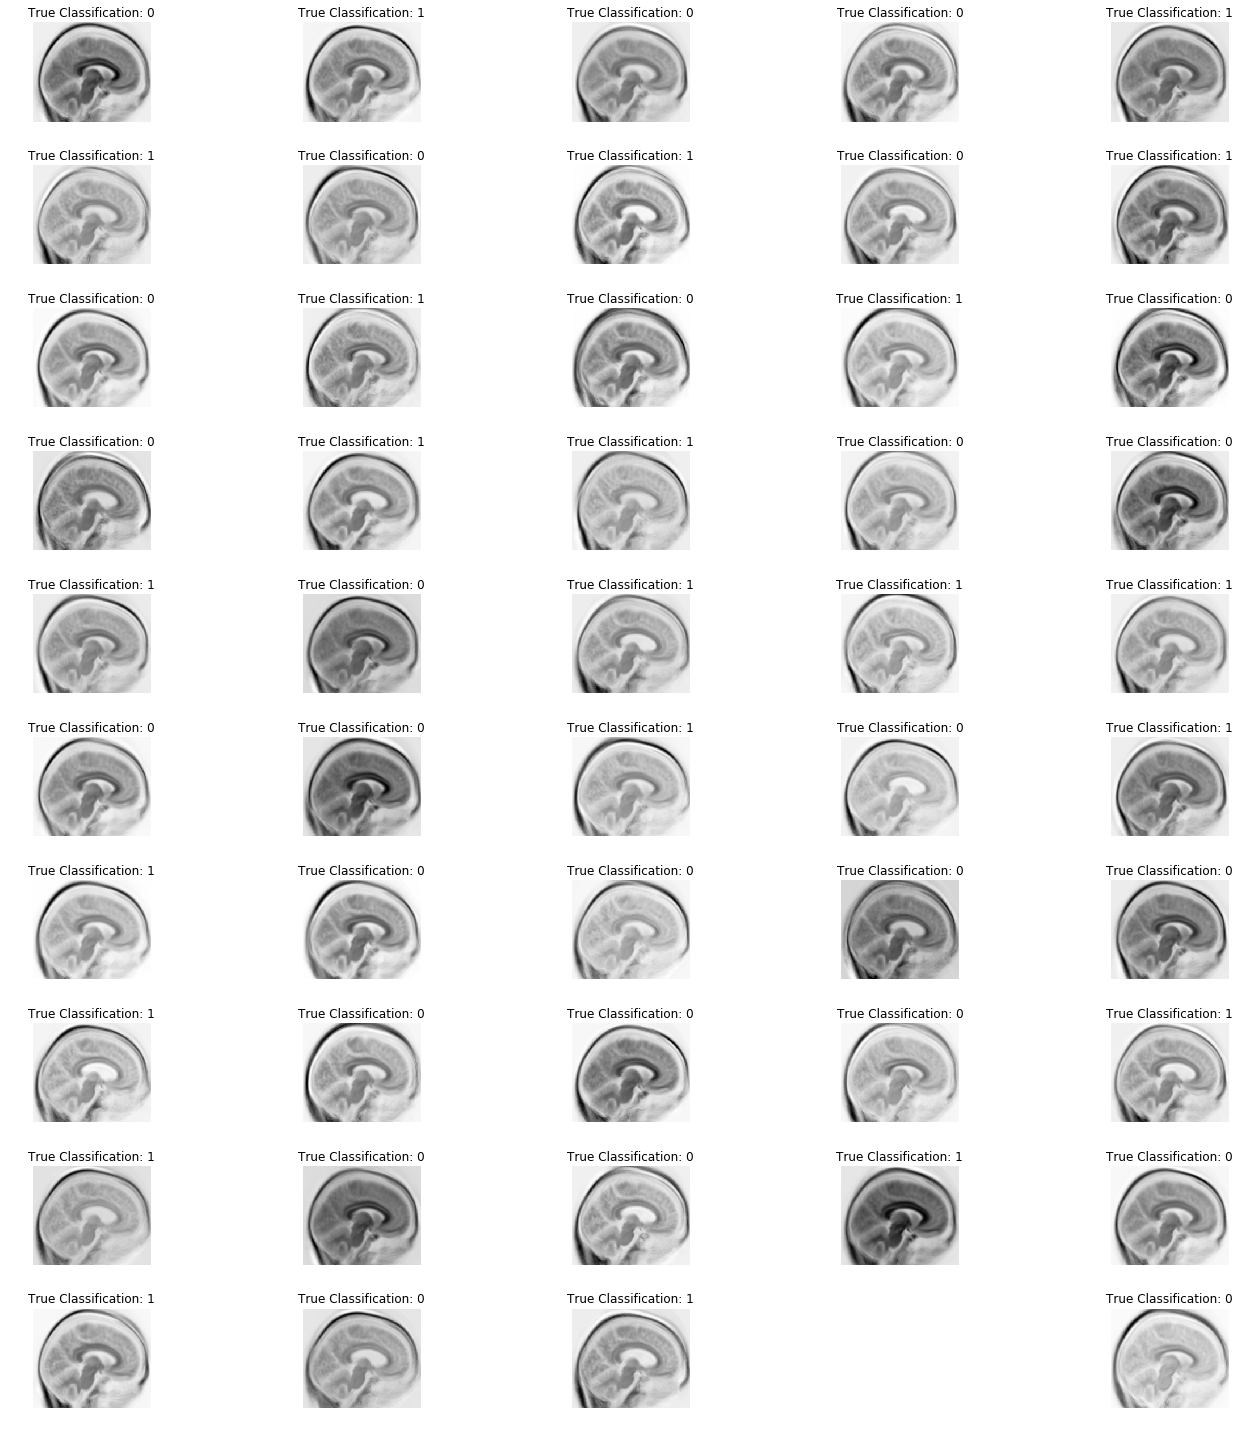

In [116]:
plt.figure(figsize=(20,20))

for x,i in enumerate(wrong_predictions):
    plt.subplot(10, 5, x+1)
    plt.title('True Classification: ' + str(df.loc[rndperm[i],'label']))
    plt.imshow(xback[i], cmap=plt.cm.Greys)
    plt.axis('off')
    plt.tight_layout()
plt.show()

In [117]:
len(correct_predictions)

108

In [118]:
correct_predictions = correct_predictions[:20]

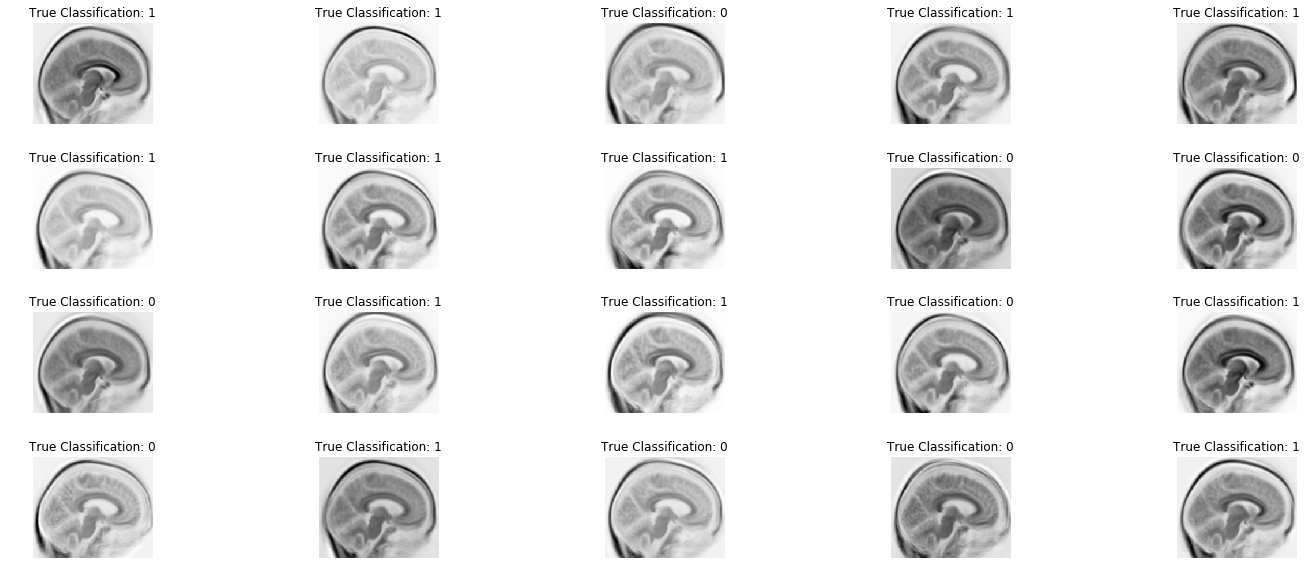

In [119]:
plt.figure(figsize=(20,20))

for x,i in enumerate(correct_predictions):
    plt.subplot(10, 5, x+1)
    plt.title('True Classification: ' + str(df.loc[rndperm[i],'label']))
    plt.imshow(xback[i], cmap=plt.cm.Greys)
    plt.axis('off')
    plt.tight_layout()
plt.show()

# Cor

In [38]:
disc_list, brain_list, total_subjects = get_slice(orientation = ['cor','110'])

subjects = get_diagnosis(total_subjects)

brain_array, alz_subjects = balance_set(subjects, total_subjects, disc_list, orientation = ['cor','110'])

subjects = get_diagnosis(total_subjects)

shape = brain_array.shape
input_shape = shape[1]*shape[2]
shape

x = brain_array
y = np.asarray(subjects['Diagnosis'])

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0448_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0448_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0449_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0449_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0439_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0439_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, 

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0208_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0208_MR1_mpr_n3_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0220_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0220_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0195_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0195_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, for

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc9/OAS1_0331_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0331_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc9/OAS1_0319_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0319_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc9/OAS1_0327_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0327_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, for

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc5/OAS1_0177_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0177_MR1_mpr_n3_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc5/OAS1_0163_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0163_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc5/OAS1_0188_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0188_MR1_mpr_n3_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, for

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc3/OAS1_0108_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0108_MR1_mpr_n3_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc3/OAS1_0097_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0097_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc3/OAS1_0083_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0083_MR1_mpr_n4_anon_111_t88_gfc_cor_110.gif'>
  return matplotlib.image.imread(fname, for

In [39]:
x.shape

(666, 176, 176)

In [40]:
def norm(x):
    x = x.reshape(-1, 176,176,1)
    m = np.max(x)
    mi = np.min(x)
    x_norm = (x - mi) / (m - mi)
    assert (np.min(x_norm), np.max(x_norm)) == (0.0, 1.0)
    return x_norm

x_norm = norm(x)


In [41]:
X_im_train, X_im_test, y_im_train, y_im_test = train_test_split(x_norm,y, random_state = 42)

In [42]:
model = Sequential([
    Conv2D(filters=100,kernel_size=(3,3),strides=(10,10), input_shape=(176,176,1),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=50,kernel_size=(3,3),strides=(5,5),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=25,kernel_size=(3,3),strides=(1,1),padding ='same'),
    MaxPooling2D(pool_size=(1,1),padding='valid'),
    Activation('sigmoid'),
    Flatten(),
    Dense(1),
    Activation('sigmoid'),
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_im_train,y_im_train,epochs=150, batch_size=75)

Epoch 1/150
499/499 [==============================] - 1s 2ms/step - loss: 0.7510 - acc: 0.5010
Epoch 2/150
499/499 [==============================] - 0s 517us/step - loss: 0.6984 - acc: 0.5010
Epoch 3/150
499/499 [==============================] - 0s 498us/step - loss: 0.6942 - acc: 0.5050
Epoch 4/150
499/499 [==============================] - 0s 492us/step - loss: 0.6956 - acc: 0.4990
Epoch 5/150
499/499 [==============================] - 0s 500us/step - loss: 0.6937 - acc: 0.4990
Epoch 6/150
499/499 [==============================] - 0s 489us/step - loss: 0.6934 - acc: 0.4990
Epoch 7/150
499/499 [==============================] - 0s 693us/step - loss: 0.6932 - acc: 0.5431
Epoch 8/150
499/499 [==============================] - 0s 536us/step - loss: 0.6943 - acc: 0.5010
Epoch 9/150
499/499 [==============================] - 0s 494us/step - loss: 0.6933 - acc: 0.5010
Epoch 10/150
499/499 [==============================] - 0s 516us/step - loss: 0.6934 - acc: 0.4770
Epoch 11/150
499/499 

499/499 [==============================] - 0s 538us/step - loss: 0.6935 - acc: 0.5010
Epoch 84/150
499/499 [==============================] - 0s 566us/step - loss: 0.6931 - acc: 0.5010
Epoch 85/150
499/499 [==============================] - 0s 464us/step - loss: 0.6937 - acc: 0.5010
Epoch 86/150
499/499 [==============================] - 0s 469us/step - loss: 0.6931 - acc: 0.5251
Epoch 87/150
499/499 [==============================] - 0s 639us/step - loss: 0.6933 - acc: 0.4990 0s - loss: 0.6935 - acc: 0.49
Epoch 88/150
499/499 [==============================] - 0s 503us/step - loss: 0.6933 - acc: 0.4990
Epoch 89/150
499/499 [==============================] - 0s 504us/step - loss: 0.6933 - acc: 0.4950
Epoch 90/150
499/499 [==============================] - 0s 529us/step - loss: 0.6934 - acc: 0.5010
Epoch 91/150
499/499 [==============================] - 0s 467us/step - loss: 0.6932 - acc: 0.5010
Epoch 92/150
499/499 [==============================] - 0s 555us/step - loss: 0.6941 - acc: 

In [43]:
model.evaluate(X_im_test, y_im_test)

167/167 [==============================] - 0s 664us/step


[0.6775895300025712, 0.7664670665820915]

# T-SNE

In [44]:
he = keras.initializers.he_normal(seed=42)

In [45]:
x.shape

(666, 176, 176)

In [46]:
tsne = TSNE(n_components=2, init='pca', random_state=42)
assert x.shape == (666, 176, 176)
X = x.reshape((666,176*176))
X_tsne = tsne.fit_transform(X)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [47]:
def run_tsne(x, y):
    X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_tsne,y, random_state = 42)
    
    model_t = Sequential([
    Dense(60, input_shape=(2,), kernel_initializer=he),
    Activation('sigmoid'),
    Dense(30),
    Activation('sigmoid'),
    Dense(15),
    Activation('sigmoid'),
    Dense(1),
    Activation('sigmoid'),
    ])
    optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_t.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return X, model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne

In [135]:
X, model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne= run_tsne(x,y)

In [136]:
# tboard = keras.callbacks.TensorBoard(log_dir='/Users/glynismattheisen/Desktop/Final',histogram_freq=5, write_graph=True, write_images=True)

In [137]:
model_t.fit(X_t_train,y_t_train,epochs=100, batch_size=50, validation_split=0.2)

Train on 399 samples, validate on 100 samples
Epoch 1/100
399/399 [==============================] - 1s 1ms/step - loss: 0.7108 - acc: 0.4737 - val_loss: 0.6798 - val_acc: 0.5700
Epoch 2/100
399/399 [==============================] - 0s 34us/step - loss: 0.6780 - acc: 0.5414 - val_loss: 0.6577 - val_acc: 0.6300
Epoch 3/100
399/399 [==============================] - 0s 34us/step - loss: 0.6638 - acc: 0.6165 - val_loss: 0.6415 - val_acc: 0.6500
Epoch 4/100
399/399 [==============================] - 0s 39us/step - loss: 0.6573 - acc: 0.6241 - val_loss: 0.6344 - val_acc: 0.6800
Epoch 5/100
399/399 [==============================] - 0s 47us/step - loss: 0.6491 - acc: 0.6241 - val_loss: 0.6279 - val_acc: 0.6800
Epoch 6/100
399/399 [==============================] - 0s 41us/step - loss: 0.6530 - acc: 0.6216 - val_loss: 0.6248 - val_acc: 0.6800
Epoch 7/100
399/399 [==============================] - 0s 45us/step - loss: 0.6446 - acc: 0.6266 - val_loss: 0.6186 - val_acc: 0.6900
Epoch 8/100
399/3

In [138]:
model_t.evaluate(X_t_test,y_t_test)

167/167 [==============================] - 0s 43us/step


[0.691755192008561, 0.6467065875401754]

In [139]:
prediction = model_t.predict_classes(X_t_test)

# Visualize the T-SNE

In [140]:
feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

# x, y = None, None

print ('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (666, 30977)


In [141]:
rndperm = np.random.permutation(df.shape[0])

<Figure size 432x288 with 0 Axes>

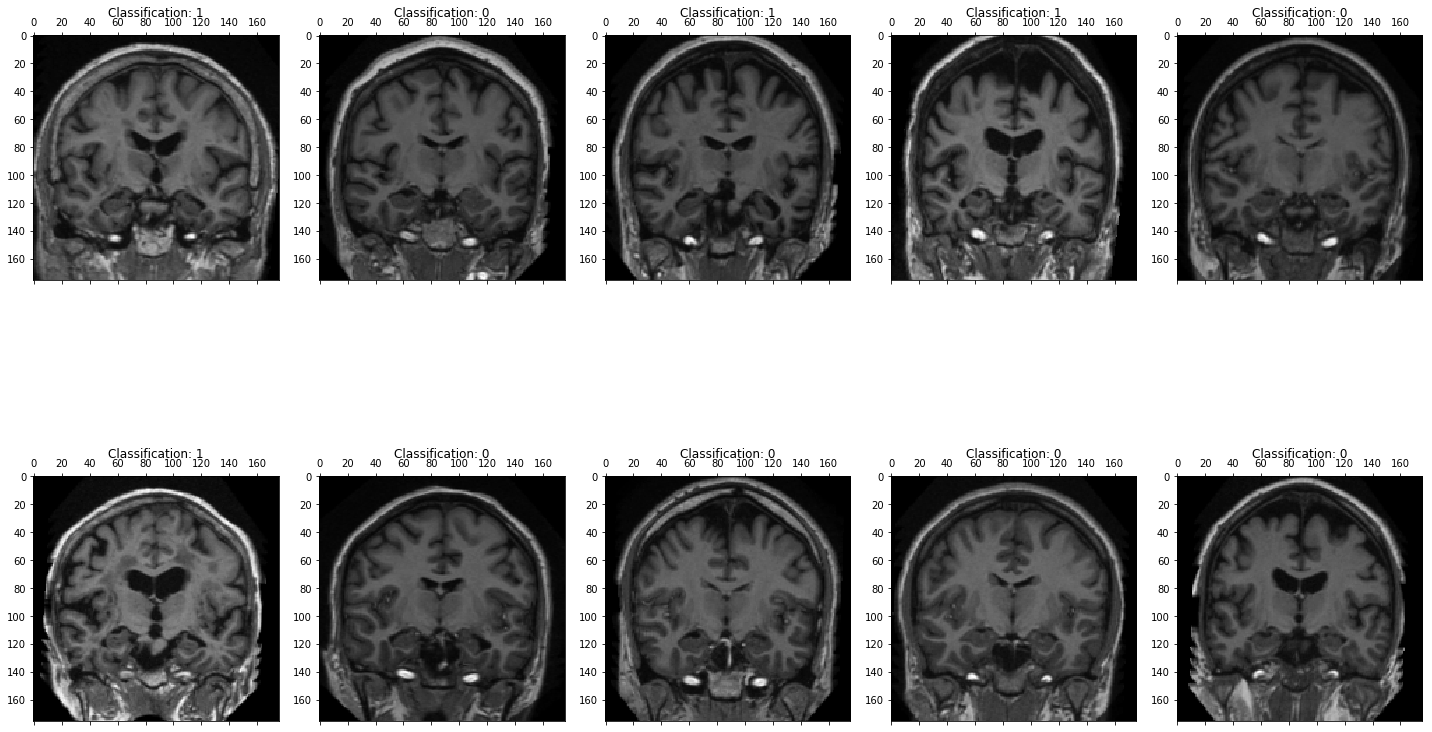

In [144]:
%matplotlib inline

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(20,20) )
for i in range(0,10):
    ax = fig.add_subplot(3,5,i+1, title='Classification: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((176,176)).astype(float))
    plt.tight_layout()
plt.show()

In [145]:
n_sne = 7000
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


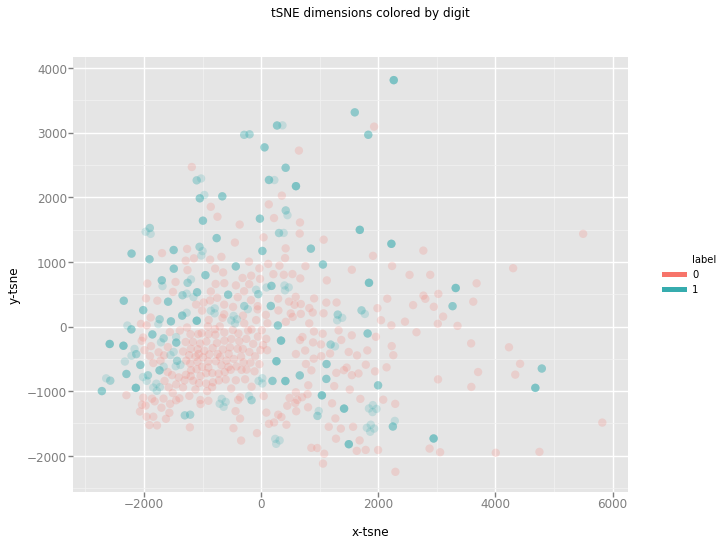

<ggplot: (-9223372029284808241)>

In [146]:
df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

ggplot.ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label')) + geom_point(size=70,alpha=0.2) + ggtitle("tSNE dimensions colored by digit")

# Tra

In [148]:
disc_list, brain_list, total_subjects = get_slice(orientation = ['tra','90'])

subjects = get_diagnosis(total_subjects)

brain_array, alz_subjects = balance_set(subjects, total_subjects, disc_list, orientation = ['tra','90'])

subjects = get_diagnosis(total_subjects)

shape = brain_array.shape
input_shape = shape[1]*shape[2]
shape

x = brain_array
y = np.asarray(subjects['Diagnosis'])

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0448_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0448_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0449_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0449_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0439_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0439_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, for

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0454_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0454_MR1_mpr_n3_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc12/OAS1_0440_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0440_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc8/OAS1_0303_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0303_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, form

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0193_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0193_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0218_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0218_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc6/OAS1_0230_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0230_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc9/OAS1_0342_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0342_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc9/OAS1_0343_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0343_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc9/OAS1_0346_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0346_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0059_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0059_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0061_MR2/PROCESSED/MPRAGE/T88_111/OAS1_0061_MR2_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc2/OAS1_0054_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0054_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc3/OAS1_0114_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0114_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc3/OAS1_0102_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0102_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format)
/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:2152: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/glynismattheisen/Desktop/Final/Discs/disc3/OAS1_0088_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0088_MR1_mpr_n4_anon_111_t88_gfc_tra_90.gif'>
  return matplotlib.image.imread(fname, format

(666, 208, 176)

In [151]:
x.shape

(666, 208, 176)

In [152]:


def norm(x):
    x = x.reshape(-1, 208,176,1)
    m = np.max(x)
    mi = np.min(x)
    x_norm = (x - mi) / (m - mi)
    assert (np.min(x_norm), np.max(x_norm)) == (0.0, 1.0)
    return x_norm

x_norm = norm(x)


X_im_train, X_im_test, y_im_train, y_im_test = train_test_split(x_norm,y, random_state = 42)

model = Sequential([
    Conv2D(filters=100,kernel_size=(3,3),strides=(10,10), input_shape=(208,176,1),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=50,kernel_size=(3,3),strides=(5,5),padding ='same'),
    MaxPooling2D(pool_size=(2,2),padding='valid'),
    Activation('sigmoid'),
    Conv2D(filters=25,kernel_size=(3,3),strides=(1,1),padding ='same'),
    MaxPooling2D(pool_size=(1,1),padding='valid'),
    Activation('sigmoid'),
    Flatten(),
    Dense(1),
    Activation('sigmoid'),
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [153]:
model.fit(X_im_train,y_im_train,epochs=150, batch_size=75)


Epoch 1/150
499/499 [==============================] - 1s 2ms/step - loss: 0.7606 - acc: 0.4990
Epoch 2/150
499/499 [==============================] - 0s 664us/step - loss: 0.6983 - acc: 0.4990
Epoch 3/150
499/499 [==============================] - 0s 628us/step - loss: 0.6947 - acc: 0.5150
Epoch 4/150
499/499 [==============================] - 0s 592us/step - loss: 0.6953 - acc: 0.5010
Epoch 5/150
499/499 [==============================] - 0s 577us/step - loss: 0.6947 - acc: 0.5010
Epoch 6/150
499/499 [==============================] - 0s 711us/step - loss: 0.6934 - acc: 0.5010
Epoch 7/150
499/499 [==============================] - 0s 630us/step - loss: 0.6933 - acc: 0.4910
Epoch 8/150
499/499 [==============================] - 0s 636us/step - loss: 0.6933 - acc: 0.4990
Epoch 9/150
499/499 [==============================] - 0s 608us/step - loss: 0.6933 - acc: 0.4990
Epoch 10/150
499/499 [==============================] - 0s 600us/step - loss: 0.6936 - acc: 0.4990
Epoch 11/150
499/499 

In [154]:
model.evaluate(X_im_test, y_im_test)


167/167 [==============================] - 0s 2ms/step


[0.6936211129148563, 0.4970059882024091]

# T-SNE


In [155]:
he = keras.initializers.he_normal(seed=42)


tsne = TSNE(n_components=2, init='pca', random_state=42)
assert x.shape == (666, 208, 176)
X = x.reshape((666,208*176))
X_tsne = tsne.fit_transform(X)

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)


In [156]:
def run_tsne(x, y):
    X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_tsne,y, random_state = 42)
    
    model_t = Sequential([
    Dense(60, input_shape=(2,), kernel_initializer=he),
    Activation('sigmoid'),
    Dense(30),
    Activation('sigmoid'),
    Dense(15),
    Activation('sigmoid'),
    Dense(1),
    Activation('sigmoid'),
    ])
    optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model_t.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return X, model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne

X, model_t, X_t_train, X_t_test, y_t_train, y_t_test, tsne= run_tsne(x,y)

# tboard = keras.callbacks.TensorBoard(log_dir='/Users/glynismattheisen/Desktop/Final',histogram_freq=5, write_graph=True, write_images=True)

model_t.fit(X_t_train,y_t_train,epochs=100, batch_size=50, validation_split=0.2)

Train on 399 samples, validate on 100 samples
Epoch 1/100
399/399 [==============================] - 1s 2ms/step - loss: 0.6643 - acc: 0.6065 - val_loss: 0.5781 - val_acc: 0.7700
Epoch 2/100
399/399 [==============================] - 0s 35us/step - loss: 0.5510 - acc: 0.7544 - val_loss: 0.4792 - val_acc: 0.8100
Epoch 3/100
399/399 [==============================] - 0s 36us/step - loss: 0.5209 - acc: 0.7469 - val_loss: 0.4622 - val_acc: 0.7800
Epoch 4/100
399/399 [==============================] - 0s 34us/step - loss: 0.5199 - acc: 0.7619 - val_loss: 0.4476 - val_acc: 0.8100
Epoch 5/100
399/399 [==============================] - 0s 42us/step - loss: 0.5037 - acc: 0.7694 - val_loss: 0.4601 - val_acc: 0.8000
Epoch 6/100
399/399 [==============================] - 0s 44us/step - loss: 0.5060 - acc: 0.7569 - val_loss: 0.4552 - val_acc: 0.8200
Epoch 7/100
399/399 [==============================] - 0s 41us/step - loss: 0.5029 - acc: 0.7769 - val_loss: 0.4468 - val_acc: 0.8200
Epoch 8/100
399/3

In [157]:
model_t.evaluate(X_t_test,y_t_test)

167/167 [==============================] - 0s 56us/step


[0.47374816212111603, 0.7485029941904331]

In [158]:
prediction = model_t.predict_classes(X_t_test)

# Visualize the T-SNE


Size of the dataframe: (666, 36609)


<Figure size 432x288 with 0 Axes>

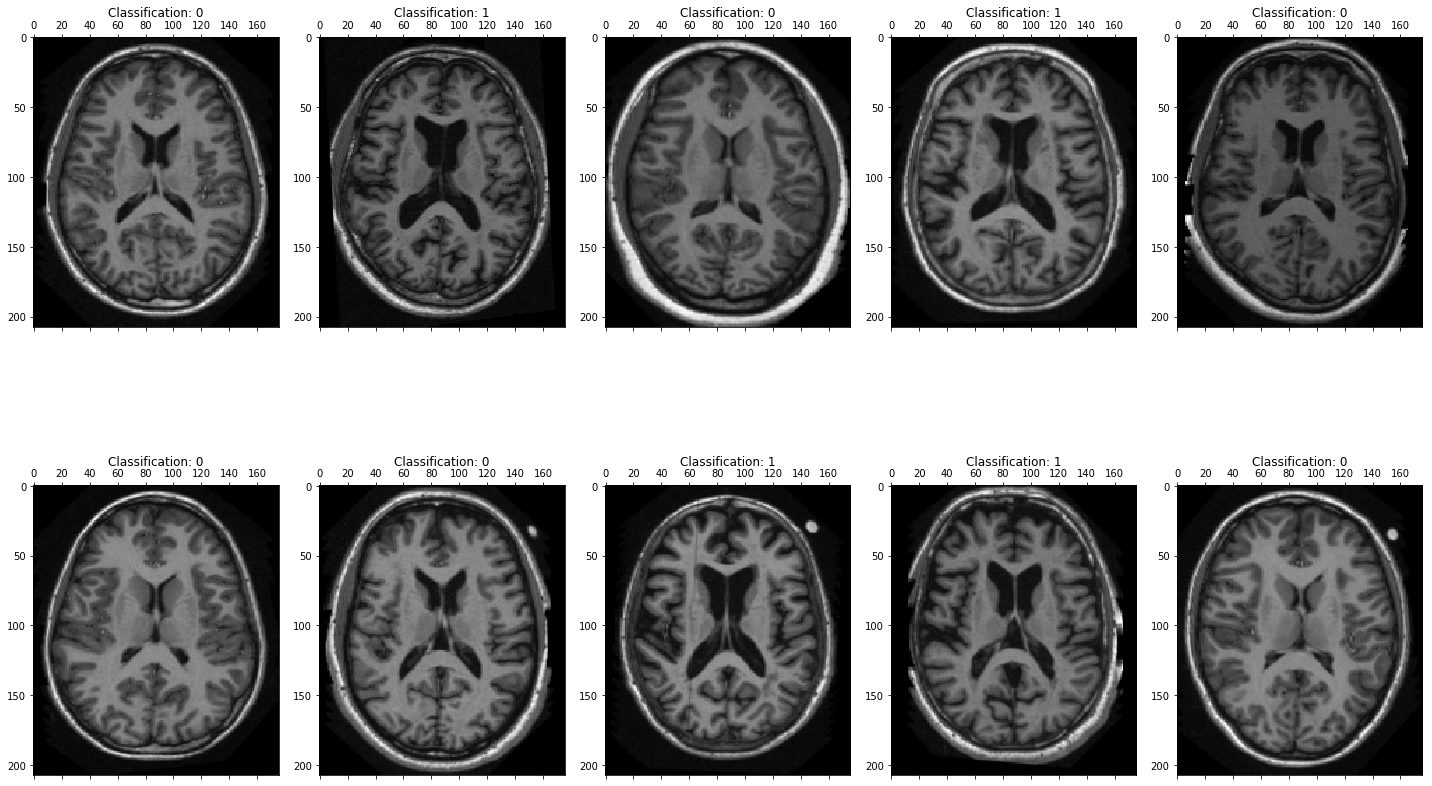

In [160]:
feat_cols = ['pixel'+str(i) for i in range(X.shape[1])]
df = pd.DataFrame(X,columns=feat_cols)
df['label'] = y
df['label'] = df['label'].apply(lambda i: str(i))

# x, y = None, None

print ('Size of the dataframe: {}'.format(df.shape))

rndperm = np.random.permutation(df.shape[0])

%matplotlib inline

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(20,20) )
for i in range(0,10):
    ax = fig.add_subplot(3,5,i+1, title='Classification: ' + str(df.loc[rndperm[i],'label']) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((208,176)).astype(float))
    plt.tight_layout()
plt.show()

/Users/glynismattheisen/anaconda3/lib/python3.6/site-packages/numpy/matrixlib/defmatrix.py:68: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


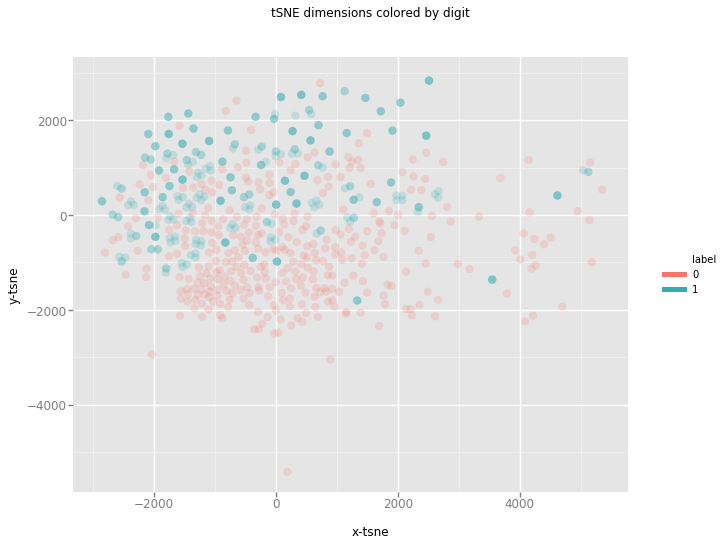

<ggplot: (7570238833)>

In [161]:
n_sne = 7000
tsne_results = tsne.fit_transform(df.loc[rndperm[:n_sne],feat_cols].values)

df_tsne = df.loc[rndperm[:n_sne],:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

ggplot.ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='label')) + geom_point(size=70,alpha=0.2) + ggtitle("tSNE dimensions colored by digit")